In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

from linear_solver import UOT_W
from sinkhorn_iterates import sinkhorn
from sinkhorn_iterates_logdomain import logsinkhorn

import torch
from scipy.linalg import sqrtm


/Users/lchapel/Documents/2024/UOT with W penalty/code/venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Figure 5: robustness to outliers with corrupted gaussians

In [14]:
np.random.seed(42)

n = 100  # nb samples
n_noise = 25 # noise on the target distribution only

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])
mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n + n_noise, mu_s, cov_s) #n+n_noise samples for the source distribution
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t) # n samples for the target distribution 

#add some noise on the target distribution only
xt = np.concatenate((xt, np.random.rand(n_noise, 2) * 20 - 8)) # and add some noisy samples on the target distribution only

a, b = np.ones((n+n_noise,)) / (n+n_noise), np.ones((n+n_noise,)) / (n+n_noise) # uniform distribution on samples
# cost matrix
C = ot.dist(xs, xt)


In [105]:
#------------OT
G0 = ot.emd(a, b, C)
cost_emd = ot.emd2(a, b, C)

overall_p = 2
X = torch.from_numpy(xs).float()
Y = torch.from_numpy(xt).float()

Cx, Cy = torch.cdist(X,X, p = overall_p), torch.cdist(Y,Y, p = overall_p)
Cx, Cy = Cx**overall_p, Cy**overall_p
a_t, b_t = torch.ones((n+n_noise,)) / (n+n_noise), torch.ones((n+n_noise,)) / (n+n_noise)
C_t = ot.dist(X, Y)

#------------factored coupling #useless here as we target anomaly detection
Ga, Gb, xb = ot.factored_optimal_transport(xs, xt, a, b, r=10)
cost_factored_coupling = np.sum(C * Ga.dot(Gb)) * 10

#------------partial OT
Pot = ot.partial.partial_wasserstein(np.ones(n+n_noise)*(n/(n+n_noise))/(n+n_noise), np.ones(n+n_noise)/(n+n_noise), C, n/(n+n_noise))
cost_Pot = ot.partial.partial_wasserstein2(a, b, C, n/(n+n_noise))
print(f"mass transported with the TV penalty: {np.sum(Pot):.2f}")

#------------kl penalty
P_kl = ot.unbalanced.mm_unbalanced(a, b, C, 50, div='kl')
pi1_kl = P_kl@np.ones((n+n_noise))
pi2_kl = (P_kl.T)@np.ones((n+n_noise))
print(f"mass transported with the KL penalty: {np.sum(P_kl):.2f}")

#------------HROT (exact)
lam = 1
P, Qx, Qy = UOT_W(a_t, b_t, C_t, lam=lam, Cx=Cx,Cy=Cy,solver="CLARABEL", innerplan = True)
a_W = P@np.ones((n+n_noise))
b_W = (P.T)@np.ones((n+n_noise))

#delete samples from the P matrix that have low mass
threshold = 3/(n)
sketches_y = np.sum(P, axis=0) 
sketches_x = np.sum(P, axis=1) 
print(f"nb of sketches transported with OT penalty: {np.sum(sketches_y >(1/n))}")
mass_samples_x = np.sum(P,axis=1).dot(Qx)*(n+n_noise)
mass_samples_y = np.sum(P,axis=0).dot(Qy)*(n+n_noise)

pos_nominal_y = np.where(mass_samples_y > threshold)[0]
pos_outliers_y = np.where(mass_samples_y <= threshold)[0]

print(len(pos_outliers_y), len(pos_outliers_y))
print(pos_outliers_y)


#------------HROT (sinkhorn solver)
P_sin, Qx_sin, Qy_sin = logsinkhorn(a_t, b_t, C_t, lam=1, eps2=0.5, eps=0.5, numiter=30, pen="sinkhorn", Cx = ot.dist(X, X), Cy = ot.dist(Y, Y), numiter2=10, innerplan=True)
P_sin = P_sin.numpy()
Qx_sin = Qx_sin.numpy()
Qy_sin = Qy_sin.numpy()

sketches_y_sin = np.sum(P_sin, axis=0) 
print(f"nb of sketches transported with OT penalty (sinkhorn): {np.sum(sketches_y_sin >(1/n))}")
mass_samples_x_sin = np.sum(P_sin,axis=1).dot(Qx_sin)*(n+n_noise)
mass_samples_y_sin = np.sum(P_sin,axis=0).dot(Qy_sin)*(n+n_noise)

threshold = np.sort(mass_samples_y_sin)[n_noise-1] #we can provide the prop of outliers
pos_nominal_y_sin = np.where(mass_samples_y_sin > threshold)[0]
pos_outliers_y_sin = np.where(mass_samples_y_sin <= threshold)[0]
print(len(pos_outliers_y_sin), len(pos_nominal_y_sin))
print(pos_outliers_y_sin)




mass transported with the TV penalty: 0.80
mass transported with the KL penalty: 0.75
nb of sketches transported with OT penalty: 10
21 21
[100 101 102 103 104 105 106 108 109 110 111 112 113 114 117 118 120 121
 122 123 124]
nb of sketches transported with OT penalty (sinkhorn): 7
25 100
[ 17  36  68  71 100 101 102 103 104 105 106 108 109 110 111 112 113 115
 117 118 120 121 122 123 124]


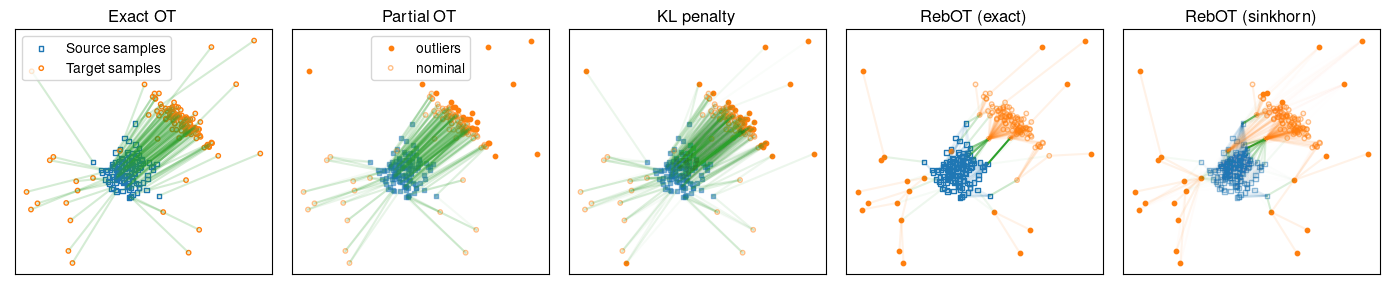

In [112]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
pl.figure(2, (14, 3))

s2 = 10
s = 500
pl.subplot(1, 5, 1)
ot.plot.plot2D_samples_mat(xs, xt, G0,c='C2', alpha=0.2)
pl.scatter(xs[:, 0], xs[:, 1],  edgecolors='C0' ,s=s2, facecolors='none', label='Source samples', marker="s")
pl.scatter(xt[:, 0], xt[:, 1], edgecolors='C1' ,s=s2, facecolors='none', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.legend()
pl.tight_layout()

pl.title('Exact OT')


#-------Partial OT
pl.subplot(1, 5, 2)
ot.plot.plot2D_samples_mat(xs, xt, Pot, c='C2', alpha=0.2)

pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=s2, marker="s",alpha=0.5)
#outliers
pl.scatter(xt[np.sum(Pot, 0) < 1e-5, 0], xt[np.sum(Pot, 0) < 1e-5, 1], c='C1',s=s2, label='outliers')
#nominal
pl.scatter(xt[np.sum(Pot, 0) >= 1e-5, 0], xt[np.sum(Pot, 0) >= 1e-5, 1], facecolors='none', edgecolors='C1',s=s2, label='nominal', alpha=0.5)
pl.xticks([])
pl.yticks([])
pl.legend()
pl.tight_layout()
pl.title('Partial OT')

#-------KL penalty OT
pl.subplot(1, 5, 3)
ot.plot.plot2D_samples_mat(xs, xt, P_kl, c='C2', alpha=0.2)

pl.scatter(xs[:, 0], xs[:, 1], c='C0',s=s2, marker="s",alpha=0.5)
#outliers
thres_out_kl = np.quantile(np.sum(P_kl, 0), 0.25)
pl.scatter(xt[np.sum(P_kl, 0) < thres_out_kl, 0], xt[np.sum(P_kl, 0) < thres_out_kl, 1], c='C1',s=s2, label='outliers')
#nominal
pl.scatter(xt[np.sum(P_kl, 0) >= thres_out_kl, 0], xt[np.sum(P_kl, 0) >= thres_out_kl, 1], facecolors='none', edgecolors='C1',s=s2, label='nominal', alpha=0.5)
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('KL penalty')

#-------RebOT (exact)
pl.subplot(1, 5, 4)

ot.plot.plot2D_samples_mat(xs, xt, P, c='C2')
ot.plot.plot2D_samples_mat(xs, xs, Qx, c='C0',alpha=0.1)
ot.plot.plot2D_samples_mat(xt, xt, Qy, c='C1',alpha=0.1)

pl.scatter(xs[:, 0], xs[:, 1], facecolors='none', edgecolors='C0', s=s2, marker= "s")
#pl.scatter(xt[:, 0], xt[:, 1], c='C1',s=b_W*s)
pl.scatter(xt[pos_outliers_y, 0], xt[pos_outliers_y, 1], c='C1',s=s2, label='outliers')
#nominal
pl.scatter(xt[pos_nominal_y, 0], xt[pos_nominal_y, 1], facecolors='none', edgecolors='C1', s=s2, label='nominal', alpha=0.5)
pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.tight_layout()
pl.title('RebOT (exact)')

#-------Rebot (sinkhorn)
pl.subplot(1, 5, 5)

ot.plot.plot2D_samples_mat(xs, xt, P_sin, c='C2', alpha=1)
ot.plot.plot2D_samples_mat(xs, xs, Qx_sin, c='C0', alpha=0.1)
ot.plot.plot2D_samples_mat(xt, xt, Qy_sin, c='C21', alpha=0.1)

pl.scatter(xs[:, 0], xs[:, 1], facecolors='none', edgecolors='C0', s=s2, marker="s",alpha=0.5)
#outliers
pl.scatter(xt[pos_outliers_y_sin, 0], xt[pos_outliers_y_sin, 1], c='C1',s=s2, label='outliers')
#nominal
pl.scatter(xt[pos_nominal_y_sin, 0], xt[pos_nominal_y_sin, 1], facecolors='none', edgecolors='C1', s=s2, label='nominal', alpha=0.5)

pl.xticks([])
pl.yticks([])
pl.tight_layout()
pl.title('RebOT (sinkhorn)')


pl.savefig("illustration_with_noise.pdf",bbox_inches='tight')


